# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 25rd 2025

**Student Name**: Andre Jair Sanchez Contreras 

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("Examples on SparkSQL")
         .master("local[*]")
         .getOrCreate())

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/28 02:01:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
# Import your module
from AndreModule.spark_utils import SchemaGenerator
from pyspark.sql.functions import get_json_object, col

su = SchemaGenerator()  


In [14]:
agencies_schema     = su.generate_schema([("agency_id", "IntegerType"),
                                          ("agency_info", "StringType")])

cars_schema         = su.generate_schema([("car_id", "IntegerType"),
                                          ("car_info", "StringType")])

customers_schema    = su.generate_schema([("customer_id", "IntegerType"),
                                          ("customer_info", "StringType")])

rental_cars_schema  = su.generate_schema([("rental_id", "IntegerType"),
                                          ("rental_info", "StringType")])


In [23]:
base_path = "/opt/spark/work-dir/data/"  

agencies_df = (spark.read
    .schema(agencies_schema)
    .option("header", "true")
    .csv(base_path + "car_service/agencies"))
agencies_df = agencies_df.withColumn("agency_name",
                                     get_json_object(col("agency_info"), "$.agency_name")) \
                         .drop("agency_info")

cars_df = (spark.read
    .option("header", "true")
    .schema(cars_schema)
    .csv(base_path + "car_service/cars"))
cars_df = cars_df.withColumn("car_name",
                             get_json_object(col("car_info"), "$.car_name")) \
                 .drop("car_info")

brands_df = (spark.read
    .option("header", "true")
    .schema(cars_schema)  
    .csv(base_path + "car_service/brands"))

customers_df = (spark.read
    .option("header", "true")
    .schema(customers_schema)
    .csv(base_path + "car_service/customers"))
customers_df = customers_df.withColumn("customer_name",
                                       get_json_object(col("customer_info"), "$.customer_name")) \
                           .drop("customer_info")

rental_cars_df = (spark.read
    .option("header", "true")
    .schema(rental_cars_schema)
    .csv(base_path + "car_service/rentals"))
rental_cars_df = (rental_cars_df
    .withColumn("car_id",      get_json_object(col("rental_info"), "$.car_id").cast("int"))
    .withColumn("customer_id", get_json_object(col("rental_info"), "$.customer_id").cast("int"))
    .withColumn("agency_id",   get_json_object(col("rental_info"), "$.agency_id").cast("int"))
    .drop("rental_info"))


In [17]:
rental_cars_df = (rental_cars_df
    .join(cars_df,      on="car_id",      how="left")
    .join(customers_df, on="customer_id", how="left")
    .join(agencies_df,  on="agency_id",   how="left"))

rental_cars_df.show(5, truncate=False)


+---------+-----------+------+---------+-----------------------+---------------+-------------+
|agency_id|customer_id|car_id|rental_id|car_name               |customer_name  |agency_name  |
+---------+-----------+------+---------+-----------------------+---------------+-------------+
|1        |71         |21    |11891    |Wallace-Carlson Model 9|Margaret Jones |NYC Rentals  |
|2        |52         |11    |11892    |Grimes-Green Model 8   |Albert Williams|LA Car Rental|
|4        |116        |22    |11893    |Stewart-Allen Model 5  |Caleb Fleming  |SF Cars      |
|1        |107        |5     |11894    |Campos PLC Model 4     |Andrew Butler  |NYC Rentals  |
|4        |53         |4     |11895    |Wagner LLC Model 1     |Kristin Potts  |SF Cars      |
+---------+-----------+------+---------+-----------------------+---------------+-------------+
only showing top 5 rows


In [ ]:
!pwd

In [18]:
rental_cars_df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")

In [7]:
rental_cars_df.write \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/rentals/csv")

In [8]:
rental_cars_df.write \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/rentals/parquet")

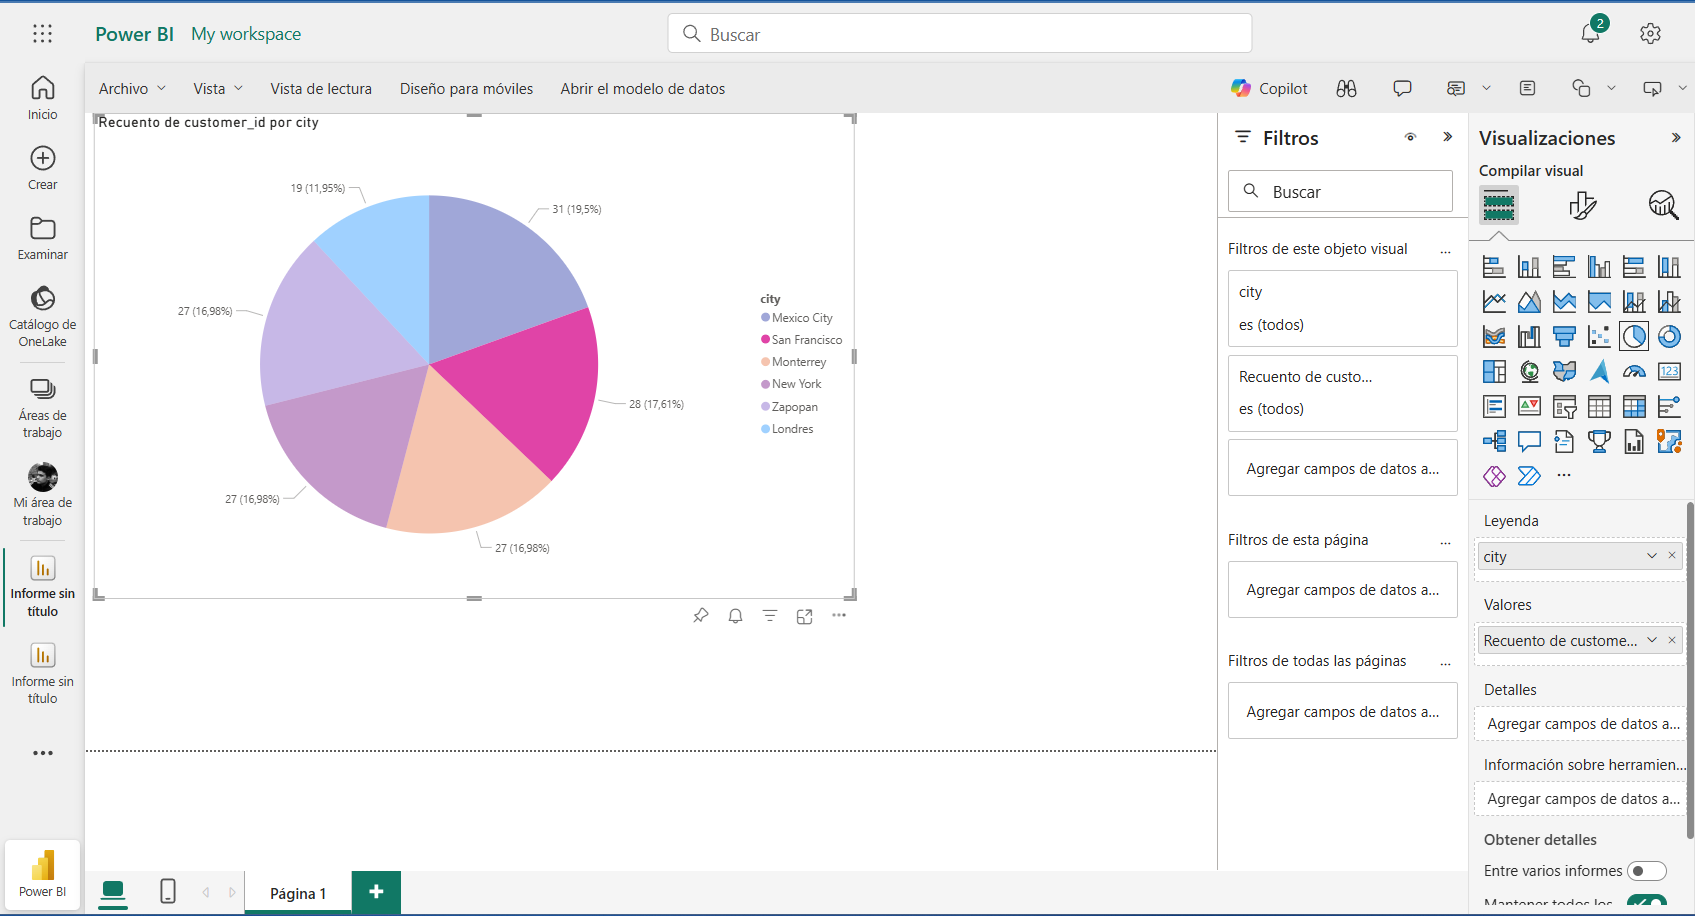

In [ ]:
sc.stop()